# 4. 모델 훈련

**기본설정**

파이썬 3.7 이상을 요구한다.

In [1]:
import sys

assert sys.version_info >= (3, 7)

사이킷런 1.0.1 이상을 요구한다.

In [2]:
import sklearn

assert sklearn.__version__ >= "1.0.1"

다음은 이미지에 포함된 폰트 크기를 설정한다.

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 4.1. 선형 회귀

선형 회귀 모델을 구현하는 과정을 살펴본다.

아래 코드는 선형 회귀 모델 훈련에 사용될 데이터 100개를 무작위로 생성한다.
`y = 4 + 3 * X ` 1차 함수를 모델로 하는 데이터이며
약간의 잡음이 추가된다.

In [4]:
import numpy as np

np.random.seed(42)

# 데이터셋 크기
m = 100
# 입력 데이터셋: 0에서 2 사이의 임의의 값 100개.
X = 2 * np.random.rand(m, 1)
# 타깃: y = 4 + 3*X 함수를 이용한 타깃값 생성. 잡음 추가.
y = 4 + 3 * X + np.random.randn(m, 1)

데이터를 산점도로 그리면 잡음 때문에 일직선이 아니지만
그래도 꽤 선형적으로 퍼져 있는 데이터 분포를 확인할 수 있다.

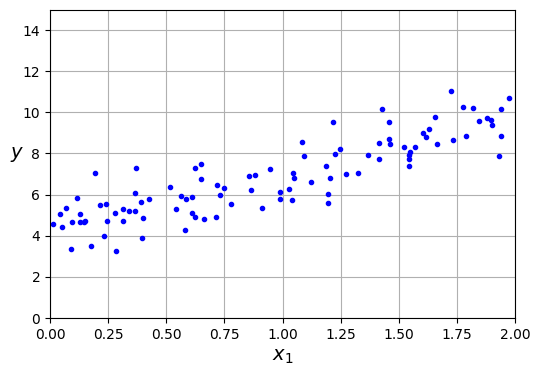

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

### `LinearRegression` 모델

사이킷런의 `LinearRegression` 모델은 경사하강법을 이용하지 않는다.
대신 무어-펜로즈 유사 역행렬을 이용하여
선형 회귀 모델이 사용하는 최적의 절편과 기울기를 계산한다.

In [6]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# 절편과 기울기
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

예측은 `predict()` 메서드를 이용한다.
아래 그래프에서 사용된 빨강 직선을 그리기 위해 필요하다.
이유는 앞서 찾아낸 최적의 모델은 직선으로 그릴 수 있으며
직선을 그릴 때 두 점이 필요하기 때문이다.

In [7]:
X_new = np.array([[0], [2]])
y_predict = lin_reg.predict(X_new)
y_predict

array([[4.21509616],
       [9.75532293]])

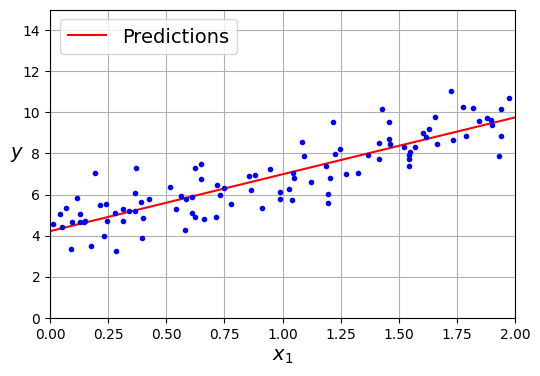

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

# 빨간 직선: (0, 4.21509616)과 (2, 9.75532293) 두 점을 지나는 직선
plt.plot(X_new, y_predict, "r-", label="Predictions")
# 데이터셋 산점도
plt.plot(X, y, "b.")

# 그래프 추가 설정
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15]) # x-축 범위: 0~2, y-축 범휘: 0~15
plt.grid()
plt.legend(loc="upper left")

plt.show()

## 4.2. 경사하강법

사이킷런의 모델을 포함하여 경사하강법을 활용하는 모든 모델은 일반적으로 배치 경사하강법 대신 확률적 또는 미니 배치 경사하강법만 지원한다.
이유는 배치 경사하강법은 작은 데이터셋에 대해서만 실용적으로 활용할 수 있기 때문이다.

### 배치 경사하강법

사이킷런은 배치 경사하강법을 전혀 지원하지 않는다.
하지만 `X`가 100개의 샘플을 담은 작은 데이터셋이기에 배치 경사하강법 훈련이 가능하기에 직접 구현해본다.

이를 위해 먼저 예측값 계산에 필요한 행렬 연산을 위한 준비 작업이 필요하다.

아래 코드는 행렬 연산을 이용한 예측값 계산을 위해 `X`를 아래 모양의 행렬로 변환하고
`X_b`가 가리키도록 한다.

$$
\mathbf{X}=
\begin{bmatrix}
1, x_1^{(0)}, \,\,\,\,\dots\,\,\,\,\,\, , x_n^{(0)} \\
\vdots \\
1, x_1^{(m-1)}, \dots, x_n^{(m-1)} \\
\end{bmatrix}
$$

`add_dummy_feature()` 함수가 0번 열에 1로 구성된 벡터를 추가한다.

In [9]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)

아래 코드는 선형회귀 모델을 경사하강법으로 훈련시키는 과정에서
학습되는 편향(절편)과 가중치(기울기) 파라미터를 이용하여
직선을 그리기 위해 사용되는 두 점의 x-좌표를 지정한다.
`add_dummy_feature()` 함수를 적용하는 이유는 역시나 행렬 연산에 필요한 1을 추가하기 위함이다.

경사하강법이 진행되면서 에포크마다 편향(절편)과 가중치(기울기) 파라미터가 업데이트 될 때마다 두 x-좌표값에 대한 예측값(y-좌표)이 달라지기에 두 점을 연결하는 직선이 달라지게 된다.

In [10]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)  # add x0 = 1 to each instance

아래 코드의 `plot_gradient_descent()` 함수의 본문에 사용된 `for` 반복문이
배치 경사하강법을 직접 구현한다.

- 그레이디언트 벡터 계산

    ```python
    gradients = 2 / m * X_b.T @ (X_b @ theta - y)
    ```

- 편형과 가중치 파라미터 업데이트

    ```python
    theta = theta - eta * gradients
    ```

`for` 반복문의 `if` 조건문은 경사하강법을 시작하고서 20 에포크 동안 학습된 편향(기울기)과 가중치(기울기) 파라미터를 이용하여 앞서 언급된 두 x 값에 대한 예측값의 변화를 이용하여 그때까지 학습된 선형 회귀 모델을 직선 그래프로 보여주기 위해 사용되었다.
따라서 경사하강법 훈련과는 직접적인 관련이 없다.

In [11]:
# extra code – generates and saves Figure 4–8

import matplotlib as mpl

def plot_gradient_descent(theta, eta):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_epochs = 1000
    n_shown = 20
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)

        # 그레이디언트 벡터 계산과 파라미터 업데이트
        gradients = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradients

        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(fr"$\eta = {eta}$")
    return theta_path

아래 코드는 학습률이 너무 작거나, 적당하거나, 너무 클 때 경사하강법을 이용한 선형 회귀 모델의 훈련 진행 과정을 잘 보여준다.

- `theta_path_bgd` 변수: 학습률 0.1을 이용하여 경사하강법을 적용하는 과정동안 학습되는 파라미터들의 리스트 저장

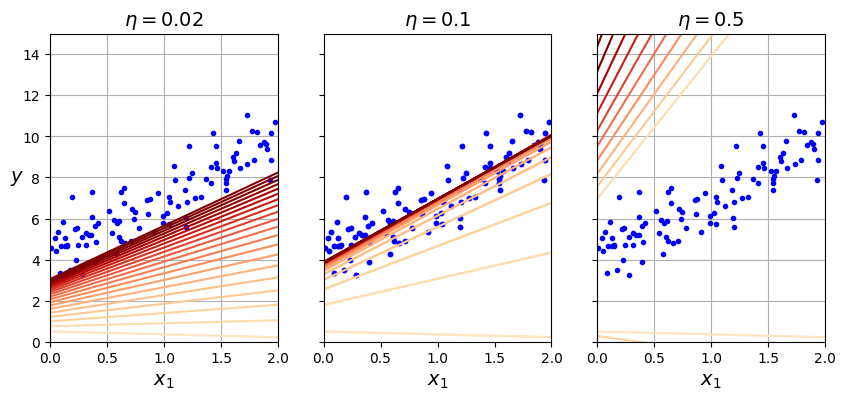

In [12]:
np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

plt.figure(figsize=(10, 4))

plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0)

plt.subplot(132)
plot_gradient_descent(theta, eta=0.1)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)
plt.gca().axes.yaxis.set_ticklabels([])

plt.subplot(133)
plt.gca().axes.yaxis.set_ticklabels([])
plot_gradient_descent(theta, eta=0.5)
plt.show()

## 확률적 경사하강법

아래 코드는 확률적 경사하강법을 이용하여 선형 회귀 모델을 훈련시키는 과정을 직접 구현한다.

- `theta_path_sgd` 변수: 확률적 경사하강법 훈련 시작 후 학습된 파라미터 저장

In [13]:
theta_path_sgd = []  # extra code – we need to store the path of theta in the
                     #              parameter space to plot the next figure

- `for epoch in range(n_epochs)` 반복문: 지정된 에포크 동안 경사하강법 진행
- `for iteration in range(m)` 반복문: 확률적 경사하강법 구현. 하나의 샘플에 대해 예측값을 계산한 후에 바로 파라미터 업데이트 진행

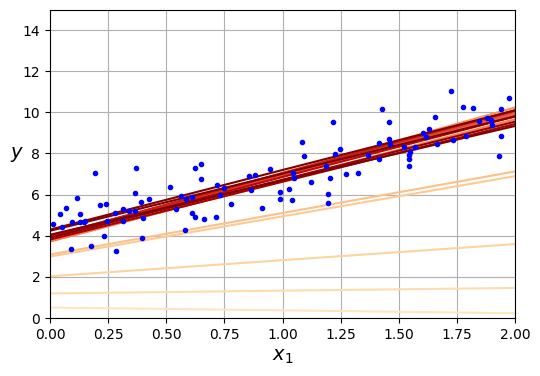

In [14]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

n_shown = 20  # extra code – just needed to generate the figure below
plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting

for epoch in range(n_epochs):
    for iteration in range(m):

        # extra code – these 4 lines are used to generate the figure
        if epoch == 0 and iteration < n_shown:
            y_predict = X_new_b @ theta
            color = mpl.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predict, color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]
        gradients = 2 * xi.T @ (xi @ theta - yi)  # for SGD, do not divide by m
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)  # extra code – to generate the figure

# extra code – this section beautifies and saves Figure 4–10
plt.plot(X, y, "b.")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([0, 2, 0, 15])
plt.grid()
plt.show()

최종적으로 학습된 파라미터는 다음과 같다.

In [15]:
theta

array([[4.21076011],
       [2.74856079]])

아래 코드는 사이킷런의 `SGDRegressor` 회귀 모델을 훈련시킨 결과로 얻어진 파라미터 또한 동일함을 보여준다.

In [16]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=1000, tol=1e-5, penalty=None, eta0=0.01,
                       n_iter_no_change=100, random_state=42)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expects 1D targets


SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [17]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

## 미니 배치 경사하강법

사이킷런의 모든 모델은 미니 배치 경사하강법을 지원하지 않으며,
아래 코드가 미니 배치 경사하강법을 직접 구현한다.

- `learning_schedule()` 함수: 에포크 내에서 스텝이 진행될 수록 학습률을 줄이는 역할을 수행하는 학습 스케줄 함수

In [18]:
from math import ceil

n_epochs = 50
minibatch_size = 20
n_batches_per_epoch = ceil(m / minibatch_size)

np.random.seed(42)
theta = np.random.randn(2, 1)  # random initialization

t0, t1 = 200, 1000  # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        idx = iteration * minibatch_size
        xi = X_b_shuffled[idx : idx + minibatch_size]
        yi = y_shuffled[idx : idx + minibatch_size]
        gradients = 2 / minibatch_size * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(iteration)
        theta = theta - eta * gradients
        theta_path_mgd.append(theta)

아래 코드는 앞서 구현한 배치/확률적/미니 배치 경사하강법을 진행할 때 학습되는 파라미터들의 변화 과정을 보여준다.

- 배치 경사하강법 파라미터 변화: 진동없이 최적 파라미터에 수렴. 하지만 훈련 시간이 가장 길고, 큰 훈련셋에서는 적용할 수 없음.
- 확률적 경가하강법 파라미터 변화: 진동 심함. 최적 파라미터 근처에서 계속 진동하고 수렴하지 못함. 하지만 학습 시간이 매우 짧아서 대용량 훈련셋에 대해 잘 작동함.
- 미니 배치 경사하강법 파라미터 변화: 진동이 상대적으로 약하며 나름 최적 파라미터에 잘 접근함. 학습 스케줄을 이용하여 훈련이 진행될 수록 학습률을 줄이면 최적 파라미터에 가깝게 근접함.

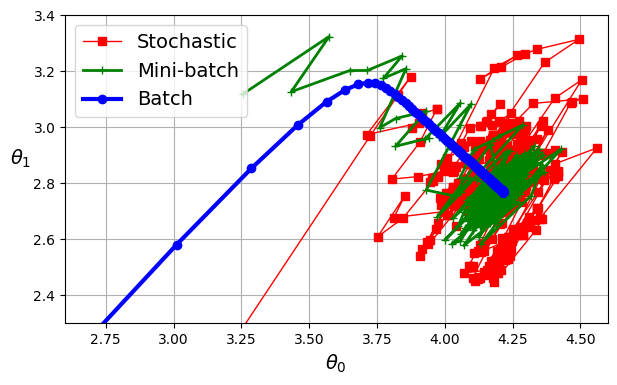

In [19]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

plt.figure(figsize=(7, 4))
plt.plot(theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1,
         label="Stochastic")
plt.plot(theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2,
         label="Mini-batch")
plt.plot(theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3,
         label="Batch")
plt.legend(loc="upper left")
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$   ", rotation=0)
plt.axis([2.6, 4.6, 2.3, 3.4])
plt.grid()
plt.show()

## 4.3. 비선형 데이터 학습: 다항 회귀

비선형 데이터를 학습하는 선형 회귀 모델을 훈련시기키 위해 다항 회귀를 적용한다.

다항 회귀 모델을 구성하는 과정을 설명하기 위해 2차 함수를 따르는 데이터셋을 생성한다.

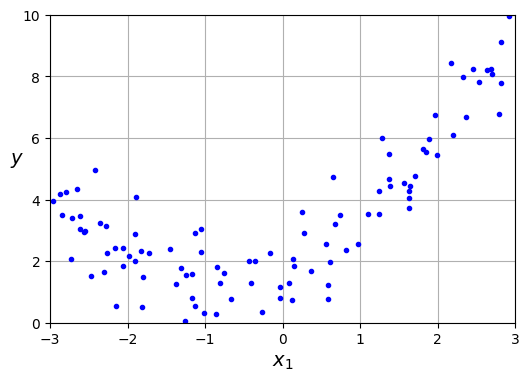

In [20]:
# 데이터셋 생성

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3                 # 입력값: -3에서 3 사이의 임의의 값 100개
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1) # 타깃: 2차 함수 활용. 잡음 추가.

# 데이터셋 산점도
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

**선형 모델 적용**

과소 적합 모델이 훈련된다.

In [21]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

# 절편과 기울기
lin_reg.intercept_, lin_reg.coef_

(array([3.56401543]), array([[0.84362064]]))

In [22]:
X_new = np.array([[-3], [3]])
y_predict = lin_reg.predict(X_new)
y_predict

array([[1.03315352],
       [6.09487734]])

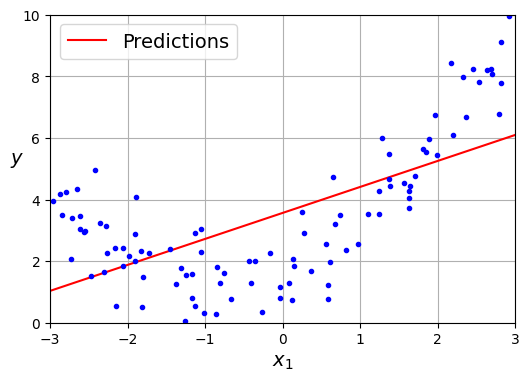

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))

# 빨간 직선: (0, 4.21509616)과 (2, 9.75532293) 두 점을 지나는 직선
plt.plot(X_new, y_predict, "r-", label="Predictions")

# 데이터셋 산점도
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])

plt.grid()
plt.legend(loc="upper left")

plt.show()

**사이킷런의 `PolynomialFeatures` 변환기**

아래 코드는 2차 항에 해당하는 특성을 새로 추가한다.

In [24]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)      # 2차 특성 추가

실행 결과 $x_1^2$ 에 해당하는 특성 $x_2$ 가 추가된 것을 확인할 수 있다.

- 원조 데이터셋의 0번 샘플: 하나의 특성 $x_1$만 사용

In [25]:
X[0]  # [x1]

array([-0.75275929])

- 변환된 데이터셋의 0번 샘플: 두 개의 특성 $x_1$, $x_1^2$ 사용

In [26]:
X_poly[0]  # [x1, x2]

array([-0.75275929,  0.56664654])

이제 선형 회귀 모델을 적용하면 적절한 절편 $\theta_0$ 과 가중치$\theta_1$ 과 $\theta_2$ 를 얻는다.

| 인스턴스 변수 | 저장된 값 | 의미 |
| :--- | :---: | :---: |
| `intercept_` | $\theta_0$ | 편향 |
| `coef_` | [ $\theta_1$, $\theta_2$ ] | 가중치 |

In [27]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

모델을 시각화하면 훈련 데이터셋을 잘 반영하는 2차 함수의 그래프가 그려진다.

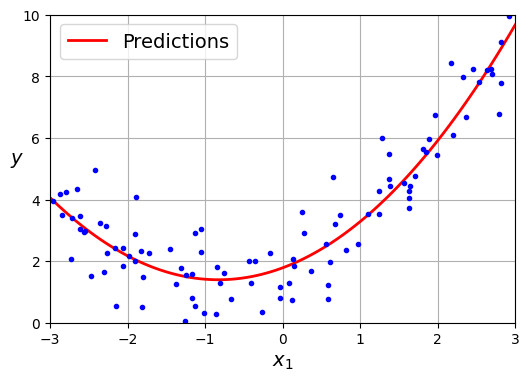

In [28]:
plt.figure(figsize=(6, 4))

# 최적의 2차 함수 그래프(빨강 곡선)
X_new = np.linspace(-3, 3, 100).reshape(100, 1)  # x1 값: -3에서 3 사이를 100등분해서 얻어지는 값.
X_new_poly = poly_features.transform(X_new)      # x1**2 특성 추가
y_new = lin_reg.predict(X_new_poly)              # 예측 타깃값
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")

# 데이터셋 X 산점도(파랑 점)
plt.plot(X, y, "b.")

plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.legend(loc="upper left")  # 범례 위치
plt.axis([-3, 3, 0, 10])      # x-축: -3부터 3까지, y-축: 0부터 10까지
plt.grid()                    # 격자 무늬 추가
plt.show()

## 4.4. 학습 곡선

아래 그림은 1차, 2차, 300차 다항 회귀의 결과를 보여준다.

- 1차 다항 회귀(선형 회귀): 과소 적합 모델
- 2차 다향 회귀: 최적 모델
- 100차 다항 회귀: 과대 적합 모델

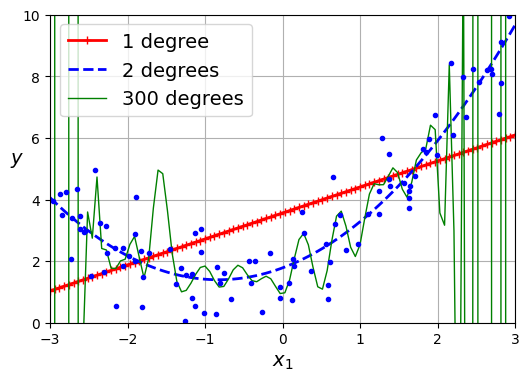

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

# 1차, 2차, 300차 다항 회귀 모델 계산
# style: 빨강 직선(-+ 기호), 파랑 파선(-- 기호), 초록 실선 등 지정
# width: 그래프 선 두께 지정
# degree; 1차, 2차, 100차 지정
for style, width, degree in (("r-+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)):
    # 고차 항 추가
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)

    # 변환 파이프라인
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)

    # 선형 회귀 모델 계산
    polynomial_regression.fit(X, y)

    # 모델별 예측값
    y_newbig = polynomial_regression.predict(X_new)

    # 그래프 그리기
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

# 데이터셋 산점도
plt.plot(X, y, "b.", linewidth=3)

plt.legend(loc="upper left")
plt.xlabel("$x_1$")
plt.ylabel("$y$", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.grid()
plt.show()

### 과소 적합 모델의 학습 곡선 특징

학습 곡선은 훈련셋과 검증 세트에 대한 모델 성능을 비교하는 그래프이며, 학습 곡선의 모양에 따라 과소 적합 또는 과대 적합 여부를 판정할 수 있다.

`learning_curve()` 함수는 학습 곡선를 그리는 데에 필요한
훈련셋의 크기, 훈련 점수, 검증 점수를 계산한다.

- `train_sizes`: 훈련셋 크기(전체의 1명부터 100명 사이의 구간)를 40등분한 값들의 리스트, 최소 1, 최대 80. 이유는 5겹 교차 검증을 사용하기에 1/5, 즉 20%는 검증셋으로 사용됨. 따라서 최대 훈련셋의 크기는 80.
- `train_scores`: 지정된 훈련셋 마다 실행된 5겹 교차 검증을 통해 생성된 훈련 점수들로 구성된 (40, 5) 모양의 2차원 어레이.
- `valid_scores`: 지정된 훈련셋 마다 실행된 5겹 교차 검증을 통해 생성된 검증 점수들로 구성된 (40, 5) 모양의 2차원 어레이.

아래 코드는 2차 함수의 분포를 따르는 데이터셋에 선형 회귀를 바로 적용하는 경우의 학습 곡선을 그릴 때 필요한 데이터를 생성한다.

In [30]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, valid_scores = learning_curve(
    LinearRegression(), X, y,
    train_sizes=np.linspace(0.01, 1.0, 40),  # 훈련셋 크기: 1% 에서 출발하여 2.5% 씩 증가
    cv=5,                                    # 5-겹 교차 검증 진행
    scoring="neg_root_mean_squared_error")   # 효용 함수: RMSE의 음숫값

train_errors = -train_scores.mean(axis=1)   # 행별 훈련 점수들의 평균값들의 1차원 어레이. 양수로 다시 변환.
valid_errors = -valid_scores.mean(axis=1)   # 행별 검증 점수들의 평균값들의 1차원 어레이 양수로 다시 변환.

In [31]:
train_sizes.shape

(40,)

In [32]:
train_scores.shape

(40, 5)

In [33]:
valid_scores.shape

(40, 5)

- 학습 곡선 그리기

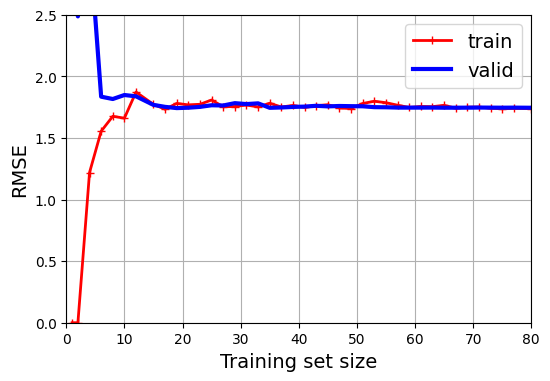

In [34]:
plt.figure(figsize=(6, 4))

plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train") # 훈련셋 크기 변화에 따른 훈련 점수 변화 그래프
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")  # 훈련셋 크기 변화에 따른 검증 점수 변화 그래프

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
plt.axis([0, 80, 0, 2.5])

plt.show()

**과대 적합 모델의 학습 곡선 특징**

과대 적합 모델은 다른 모양의 학습 곡선을 생성한다.
아래 코드는 주어진 2차 함수 모델의 데이터셋에
10차 다항 회귀를 사용하면 전형적인 과대 적합 현상이 발생함을 보여준다.

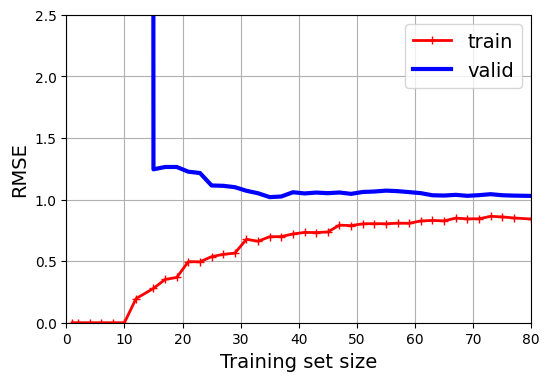

In [35]:
from sklearn.pipeline import make_pipeline

polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False),
    LinearRegression() )

train_sizes, train_scores, valid_scores = learning_curve(
    polynomial_regression, X, y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error")

train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")
plt.legend(loc="upper right")
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, 80, 0, 2.5])
plt.show()

## 4.5 모델 규제와 조기 종료

### 4.5.1. 모델 규제

확률적 경사하강법을 사용하는 `SGDRegressor` 모델이 세 종류의 규제를 지원한다.


In [36]:
from sklearn.linear_model import SGDRegressor

**릿지 회귀**

- `SGDRegressor` 클래스: `penalty='l2'` 사용

In [37]:
sgd_reg = SGDRegressor(penalty="l2", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([4.7852203])

- `Ridge` 클래스 모델
    - `solver="sag"`: 확률적 경사 하강법 실행 알고리즘
    - `alpha` 값을 `SGDRegressor`의 경우보다 보다 `len(X)` 배 만큼 큰 값을 사용해야 함.
    - `penalty="l2"`를 적용한 `SGDRegressor`모델과 가장 유사

In [38]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha=0.1 * X.shape[0], solver="sag", random_state=42)
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[4.78581985]])

**라쏘 회귀**

- `SGDRegressor` 클래스: `penalty='l1'`사용

In [39]:
sgd_reg = SGDRegressor(penalty="l1", alpha=0.1, tol=None,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([4.77557733])

- `Lasso` 클래스 모델

In [40]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([4.77621741])

**엘라스티 넷**

- `SGDRegressor` 클래스
    - `penalty='elasticnet'`:  엘라스틱 넷 회귀 지정
    - `l1_ratio=0.5`: 릿지 회귀와 라쏘 회귀 사용 비율

In [41]:
sgd_reg = SGDRegressor(penalty="elasticnet", alpha=0.1, tol=None,
                       l1_ratio=0.5,
                       max_iter=1000, eta0=0.01, random_state=42)

sgd_reg.fit(X, y.ravel())   # y.ravel(): 타깃값을 1차원 어레로 변환
sgd_reg.predict([[1.5]])

array([4.78047395])

- `ElasticNet` 클래스 모델

In [42]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([4.78114505])

### 4.5.2. 조기 종료

아래 코드는 `SGDRegressor` 모델에 조기 종료 기법을 이용할 때
규제 정도에 따라 조기 종료가 다르게 발생함을 보여준다.

- 훈련셋 준비: 2차 다항 함수의 분포를 따르는 100개의 샘플로 구성된 데이터셋 생성

In [43]:
from copy import deepcopy
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + 2 + np.random.randn(m, 1)

- `SGDRegressor` 모델
    - 여러 `alpha` 값에 반복문을 실행하면서 다양한 규제 적용 모델 확인
    - `penalty='elasticnet'`: 엘라스틱 넷 회귀 적용
    - `l1_ratio=0.5`: $\ell_1$ 벌점 강도
    - `eta0=0.002`: 학습률
    - `early_stopping=True`: 조기 종료 실행. 훈련셋의 일부를 검증셋으로 활용.
    - `max_iter=1000`: 최대 훈련 에포크
    - `tol=1e-3`: 훈련 점수 또는 검증 점수가 지정된 값 이하로 최대 `n_iter_no_change` 에포크 동안 변하지 않으면 조기 종료 실행
    - `n_iter_no_change=5`: 훈련 점수 또는 검증 점수가 지정된 에포크 동안 얼마나 변하는지 확인

- 전처리 파이프라인
    - 90차 다항 회귀 변환
    - 표준화 스케일링

- `n_iter_` 속성 변수: `SGDRegressor` 모델의 훈련이 조기종료 될 때까지 실행된 에포크 크기 저장

In [44]:
for alpha in [0, 0.01, 0.1, 0.13, 0.15, 0.2, 0.3, 0.4, 0.5, 1, 5, 10]:
    # 사용할 모델
    sgd_reg = SGDRegressor(penalty='elasticnet', alpha=alpha, l1_ratio=0.5,
                            eta0=0.002, random_state=42,
                            early_stopping=True,
                            max_iter=1000, tol=1e-3, n_iter_no_change=5)

    # 전처리 파이프라인 포함 모델 지정
    sgd = make_pipeline(PolynomialFeatures(degree=90, include_bias=False),
                                  StandardScaler(),
                                  sgd_reg)
    # 모델 훈련
    sgd.fit(X, y.ravel())

    # 실제 훈련된 에포크 크기 출력
    print(f"alpha={alpha:5.2f}일 때 실제 사용된 에포크: {sgd_reg.n_iter_:2d}")

alpha= 0.00일 때 실제 사용된 에포크:  6
alpha= 0.01일 때 실제 사용된 에포크:  6
alpha= 0.10일 때 실제 사용된 에포크:  6
alpha= 0.13일 때 실제 사용된 에포크: 137
alpha= 0.15일 때 실제 사용된 에포크: 137
alpha= 0.20일 때 실제 사용된 에포크: 131
alpha= 0.30일 때 실제 사용된 에포크: 122
alpha= 0.40일 때 실제 사용된 에포크: 112
alpha= 0.50일 때 실제 사용된 에포크: 104
alpha= 1.00일 때 실제 사용된 에포크: 82
alpha= 5.00일 때 실제 사용된 에포크: 113
alpha=10.00일 때 실제 사용된 에포크: 113


- 결론: `alpha=0.15`일 때 조기 종료가 가장 늦게 일어나며, 이런 모델의 일반화 성능이 가장 좋다.

## 4.6 로지스틱 회귀

### 4.6.1. 확률 예측

### 4.6.2. 비용 함수

### 4.6.3. 붓꽃 데이터셋

`load_iris()` 함수가 붓꽃 데이터셋을 불러온다.

In [45]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

불러온 자료형는 사전(`dict`)과 유사한 `Bunch` 자료형이며 사이킷런 라이브러리에서 제공한다.

- `Bunch` 자료형은 키를 사용한 인덱싱을 마치 클래스의 속성을 확인하는 방식으로 다룰 수 있음
- 예제: `iris['data']` 대시 `iris.data` 사용 가능

In [46]:
type(iris)

sklearn.utils._bunch.Bunch

포함된 키(key)는 다음과 같다.

In [47]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

- `DESCR` 키: 붓꽃 데이터셋에 대한 설명

In [48]:
print(iris.DESCR)  # iris['DESCR']

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

- `data` 키: 4 개의 특성으로 구성된 데이터프레임. 샘플은 총 150개.
    - `sepan length (cm)`: 꽃받침 길이
    - `sepan width (cm)`: 꽃받침 너비
    - `petal length (cm)`: 꽃잎 길이
    - `petal width (cm)`: 꽃잎 너비
- 처음 5개 데이터는 다음과 같음

In [49]:
iris.data.head(5)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


- `target` 키: 정수로 구성된 라벨셋. 1차원 어레이.

In [50]:
iris.target.head(5) # 세토사 품종 5개

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

- `target_names` 키: 라벨 실제 이름
    - `'setosa'`: 세토사. 라벨 0에 해당.
    - `'versicolor'`: 버시컬러. 라벨 1에 해당.
    - `'virginica'`: 버지니카. 라벨 2에 해당.

In [51]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

### 4.6.4. 결정 경계

**버지니카 품종 감지기: 꽃잎 너비 특성 활용**

- 꽃잎의 너비 특성 하나만 이용하여 버지니카 여부 판별

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

- 결정 경계 확인: 꽃잎 너비 1.65 기준으로 그 이상이면 버지니카 양성으로 판정

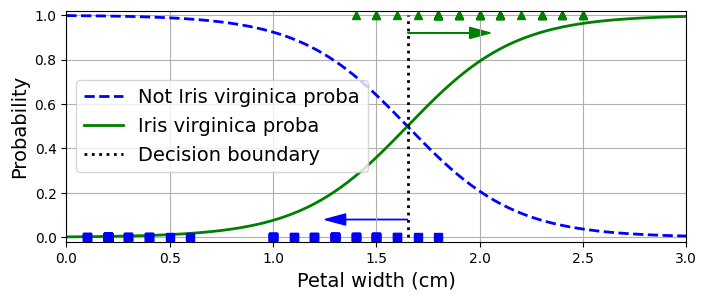

In [53]:
# 두 곡선 그래프에 필요한 x-좌표 어레이
X_new = np.linspace(0, 3, 1000).reshape(-1, 1) # 2차원 어레이로 변환
# y-좌표: 양성 예측 확률값
y_proba = log_reg.predict_proba(X_new)
# 결정 경계 확인: 양성 예측 확률이 0.5인 지점(꽃잎 너비 기준)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

# 그래프 그리기
plt.figure(figsize=(8, 3))

# 파랑 파선
plt.plot(X_new, y_proba[:, 0], "b--", linewidth=2,
         label="Not Iris virginica proba")
# 초록 실선
plt.plot(X_new, y_proba[:, 1], "g-", linewidth=2, label="Iris virginica proba")
# 결정 경계: 검정 수직 점선
plt.plot([decision_boundary, decision_boundary], [0, 1], "k:", linewidth=2,
         label="Decision boundary")

# 화살표 그리기
plt.arrow(x=decision_boundary, y=0.08, dx=-0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="b", ec="b")
plt.arrow(x=decision_boundary, y=0.92, dx=0.3, dy=0,
          head_width=0.05, head_length=0.1, fc="g", ec="g")

# 하단 파랑 네모: 일부 잘못 분류된 샘플 확인 가능
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")

# 상단 초록 세모: 일부 잘못 분류된 샘플 확인 가능
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.axis([0, 3, -0.02, 1.02])
plt.grid()

plt.show()

결정 경계는 약 1.65이다.

In [54]:
decision_boundary

1.6516516516516517

**버지니카 품종 감지기: 꽃잎 길이와 너비 특성 활용**

꽃잎의 길이와 너비 두 특성을 이용하여 붓꽃의 품종을 판별한다.

- 로지스틱 회귀 모델 훈련
    - `LogisticRegression` 클래스의 `multi_class='ovr'` 가 이진 분류의 경우 자동으로 사용됨.

In [55]:
# 두 특성만 사용하는 입력 데이터셋 준비
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == 'virginica'
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# 로지스틱 회귀 모델 준비: `C`는 규제 강도. 기본값은 1. 작은 값일 수록 큰 규제.
log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)


LogisticRegression(C=2, random_state=42)

- 결정 경계

아래 그림의 검정 파선은 아래 식을 만족시키는 (꽃잎길이 $x_1$, 꽃잎너비 $x_2$)의 점들로 구성된다.

$$
\sigma(\theta_0 + x_1 \cdot \theta_1 + x_2 \cdot \theta_2) = 0.5
$$

즉, 다음을 만족시키는 직선상의 점들이다.

$$
\theta_0 + x_1 \cdot \theta_1 + x_2 \cdot \theta_2 = 0
$$

일차 함수식으로 표현하면 다음과 같다.

$$
x_2 = - \frac{\theta_0 + x_1 \cdot \theta_1}{\theta_2}
$$

결론적으로 검정 파선은  꽃잎의 너비와 길이 두 속성을 이용했을 때 버지니카 품종의 여부를
결정하는 **결정 경계**를 나타낸다.
반면에 다양한 색상의 직선은 버지니카 품종일 가능성(확률)을 보여주는 영역을 구분한다.

편향 $\theta_0$는 `lin_reg.intercept_` 속성에, 가중치들의 리스트 $[\theta_1, \theta_2]$는 `lin_reg.coef_` 속성에 저장되어 있다.
편향과 가중치의 실제 값은 다음과 같다.
따라서 다음이 성립한다.

```
x2 = - (log_reg.coef_[0, 0] * x1 + log_reg.intercept_[0]) / log_reg.coef_[0, 1]
```

훈련을 통해 알아낸 편형과 가중치는 다음과 같다.

```python
>>> log_reg.intercept_
array([-19.39071015])

>>> log_reg.coef_
array([[3.05915555, 2.70297187]])
```

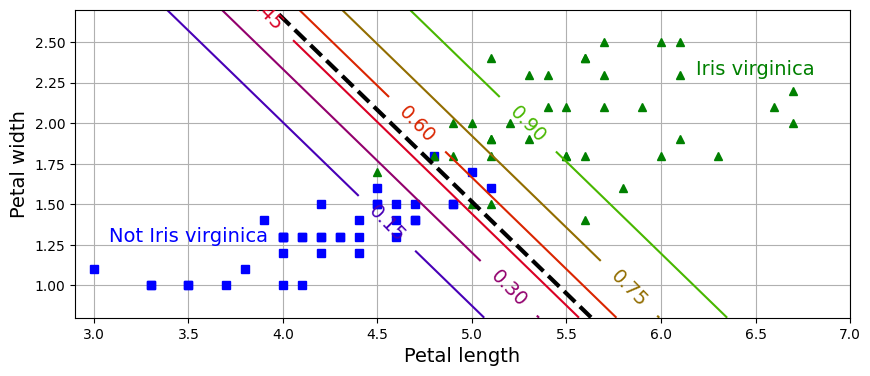

In [56]:
# 직선을 그리기 위한 데이터셋
x0, x1 = np.meshgrid(np.linspace(2.9, 7, 500).reshape(-1, 1),
                     np.linspace(0.8, 2.7, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]  # x-좌표와 y-좌표를 묶어 2개의 특성으로 지정.
y_proba = log_reg.predict_proba(X_new) # 예측 확률: 음성 확률과 양성 확률의 튜플

# 버지니카로 판정될 양성 확률을 등고선 그릴 때 사용
zz = y_proba[:, 1].reshape(x0.shape)   # 양성 예측 확률만 사용

# 결정 경계: theta0 + x1 * theta1 + x2 * theta2 = 0 을 만족시키는 직선
left_right = np.array([2.9, 7]) # 직선상에 위치한 두 점의 x-좌표
# 두 점의 y-좌표 계산
boundary = -((log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0])
             / log_reg.coef_[0, 1])

# 그래프 그리기
plt.figure(figsize=(10, 4))

# 산점도: 파랑 네모. 버지니카가 아닌 샘플
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
# 산점도: 초록 세모. 버지니카인 샘플
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")

# 등고선: 버지니카일 확률 기준
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1) # 양성 확률 함께 표시

# 결정 경계 그리기
plt.plot(left_right, boundary, "k--", linewidth=3)

# 기타 문장 표시
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")

# 축 라벨 표시
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()

## 4.7. 소프트맥스 회귀

**붓꽃 데이터 다중 클래스 분류**

꽃잎의 길이와 너비 두 특성을 이용하여 세토사, 버시컬러, 버지니카 클래스 중 하나를 선택하는 모델을 훈련시킨다.

- 소프트맥스 모델 훈련
    - `LogisticRegression` 모델을 다중 클래스 분류 모델로 훈련시키면 `multi_class='multinomial'` 옵션이
        자동 지정되어 소프트맥스 회귀를 적용함
    - `C=30`: 약한 규제

In [57]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

softmax_reg = LogisticRegression(C=30, random_state=42)
softmax_reg.fit(X_train, y_train)

LogisticRegression(C=30, random_state=42)

- 결정 경계
    - 바탕화면 색: 색상의 헥사(Hex) 값 활용
    - 참고: [W3 Schools: Color converter](https://www.w3schools.com/colors/colors_converter.asp)

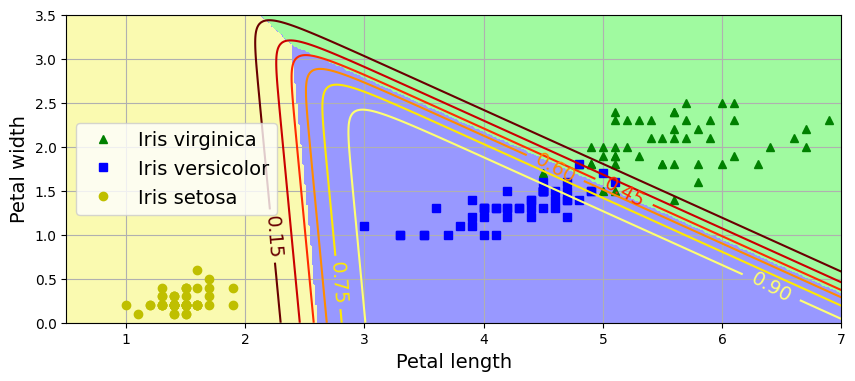

In [58]:
# 라벨 별 바탕화면 색 지정
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(["#fafab0", "#9898ff", "#a0faa0"]) # 노랑, 파랑, 초록

# 바탕화면을 그리기위한 좌표
# x-좌표
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))
X_new = np.c_[x0.ravel(), x1.ravel()]

# y-좌표
y_proba = softmax_reg.predict_proba(X_new) # 확률값 예측
y_predict = softmax_reg.predict(X_new)     # 품종 라벨 예측

# `contour` 용 y-좌표: 버시컬러 확률 기준
zz1 = y_proba[:, 1].reshape(x0.shape)
# `contourf` 용 y-좌표: 예측값 기준
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

# 등고선 그리기: 색으로 구분. 예측 확률 기준
plt.contourf(x0, x1, zz, cmap=custom_cmap)
# 등고선 그리기: 버시컬러 품종일 가능성 확률 기준
contour = plt.contour(x0, x1, zz1, cmap="hot")
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="center left")
plt.axis([0.5, 7, 0, 3.5])
plt.grid()
plt.show()

## 연습 문제

## 1. to 11.

1. If you have a training set with millions of features you can use Stochastic Gradient Descent or Mini-batch Gradient Descent, and perhaps Batch Gradient Descent if the training set fits in memory. But you cannot use the Normal Equation or the SVD approach because the computational complexity grows quickly (more than quadratically) with the number of features.
2. If the features in your training set have very different scales, the cost function will have the shape of an elongated bowl, so the Gradient Descent algorithms will take a long time to converge. To solve this you should scale the data before training the model. Note that the Normal Equation or SVD approach will work just fine without scaling. Moreover, regularized models may converge to a suboptimal solution if the features are not scaled: since regularization penalizes large weights, features with smaller values will tend to be ignored compared to features with larger values.
3. Gradient Descent cannot get stuck in a local minimum when training a Logistic Regression model because the cost function is convex. _Convex_ means that if you draw a straight line between any two points on the curve, the line never crosses the curve.
4. If the optimization problem is convex (such as Linear Regression or Logistic Regression), and assuming the learning rate is not too high, then all Gradient Descent algorithms will approach the global optimum and end up producing fairly similar models. However, unless you gradually reduce the learning rate, Stochastic GD and Mini-batch GD will never truly converge; instead, they will keep jumping back and forth around the global optimum. This means that even if you let them run for a very long time, these Gradient Descent algorithms will produce slightly different models.
5. If the validation error consistently goes up after every epoch, then one possibility is that the learning rate is too high and the algorithm is diverging. If the training error also goes up, then this is clearly the problem and you should reduce the learning rate. However, if the training error is not going up, then your model is overfitting the training set and you should stop training.
6. Due to their random nature, neither Stochastic Gradient Descent nor Mini-batch Gradient Descent is guaranteed to make progress at every single training iteration. So if you immediately stop training when the validation error goes up, you may stop much too early, before the optimum is reached. A better option is to save the model at regular intervals; then, when it has not improved for a long time (meaning it will probably never beat the record), you can revert to the best saved model.
7. Stochastic Gradient Descent has the fastest training iteration since it considers only one training instance at a time, so it is generally the first to reach the vicinity of the global optimum (or Mini-batch GD with a very small mini-batch size). However, only Batch Gradient Descent will actually converge, given enough training time. As mentioned, Stochastic GD and Mini-batch GD will bounce around the optimum, unless you gradually reduce the learning rate.
8. If the validation error is much higher than the training error, this is likely because your model is overfitting the training set. One way to try to fix this is to reduce the polynomial degree: a model with fewer degrees of freedom is less likely to overfit. Another thing you can try is to regularize the model—for example, by adding an ℓ₂ penalty (Ridge) or an ℓ₁ penalty (Lasso) to the cost function. This will also reduce the degrees of freedom of the model. Lastly, you can try to increase the size of the training set.
9. If both the training error and the validation error are almost equal and fairly high, the model is likely underfitting the training set, which means it has a high bias. You should try reducing the regularization hyperparameter _α_.
10. Let's see:
  * A model with some regularization typically performs better than a model without any regularization, so you should generally prefer Ridge Regression over plain Linear Regression.
  * Lasso Regression uses an ℓ₁ penalty, which tends to push the weights down to exactly zero. This leads to sparse models, where all weights are zero except for the most important weights. This is a way to perform feature selection automatically, which is good if you suspect that only a few features actually matter. When you are not sure, you should prefer Ridge Regression.
  * Elastic Net is generally preferred over Lasso since Lasso may behave erratically in some cases (when several features are strongly correlated or when there are more features than training instances). However, it does add an extra hyperparameter to tune. If you want Lasso without the erratic behavior, you can just use Elastic Net with an `l1_ratio` close to 1.
11. If you want to classify pictures as outdoor/indoor and daytime/nighttime, since these are not exclusive classes (i.e., all four combinations are possible) you should train two Logistic Regression classifiers.

## 12. 경사 하강법 훈련의 조기 종료를 지원하는 소프트맥스 회귀 구현

붓꽃 데이터셋을 대상으로 다중 클래스 분류를 진행하는 소프트맥스 회귀 모델에
사용되는 배치 경상하강법을 직접 구현한다.
또한 사이킷런은 전혀 사용하지 않고 넘파이 모듈만을 이용하며, 조기 종료 기능도 지원하도록 한다.

In [ ]:
import sklearn
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

### 붓꽃 데이터셋 준비

**붓꽃 데이터셋 적재**

In [ ]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)

훈련셋과 타깃셋을 지정한다.
훈련셋 샘플은 꽃잎의 길이와 너비 2개 특성만 사용한다.
또한 데이터프레임을 넘파이 어레이로 변환한다.

In [ ]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris["target"].values

**입력 데이터셋 변환: 항목 1 추가**

모든 훈련 샘플에 1을 첫째 특성으로 추가한다.
이유는 예측값을 계산할 때 다음과 같이 편향(bias)를 고려해서 계산이 사용되기 때문이다.

$$
1\cdot \theta_0 + x_1 \cdot \theta_1 + x_2 \cdot \theta_{2}
= [1, x_1, x_2]\,
\begin{bmatrix}
\theta_0\\
\theta_1 \\
\theta_2
\end{bmatrix}
$$

사이킷런의 `add_dummy_feature()` 함수를 이용하면 되지만 여기서는 경사하강법을 보다 깊이 이해하기 위해 직접 구현한다.

- `np_c[]`: 어레이를 좌우로 이어붙이기
- `np.ones()`: 1로 구성된 어레이 생성. 인자는 생성되는 어레이 모양(shape)

In [ ]:
X_with_bias = np.c_[np.ones(len(X)), X]

변환된 입력 데이터셋은 다음과 같다.

In [ ]:
X_with_bias[:5]

array([[1. , 1.4, 0.2],
       [1. , 1.4, 0.2],
       [1. , 1.3, 0.2],
       [1. , 1.5, 0.2],
       [1. , 1.4, 0.2]])

반면에 기존의 입력 데이터셋 `X`는 다음과 같다.

In [ ]:
X[:5]

array([[1.4, 0.2],
       [1.4, 0.2],
       [1.3, 0.2],
       [1.5, 0.2],
       [1.4, 0.2]])

**훈련셋, 검증셋, 테스트셋 구분**

사이킷런의 `train_test_split()` 함수를 이용하면 간단하지만 역시나 직접 구현한다.

- 훈련셋, 검증셋, 테스트셋 비율은 6:2:2

In [ ]:
test_ratio = 0.2              # 테스트셋 비율
validation_ratio = 0.2        # 검증셋 비율

total_size = len(X_with_bias) # 150. 전체 입력 데이터셋 크기

test_size = int(total_size * test_ratio)              # 테스트셋 크기
validation_size = int(total_size * validation_ratio)  # 검증셋 크기
train_size = total_size - test_size - validation_size # 훈련셋 크기

3개의 데이터셋으로 분류하기 전에 전체 입력 데이터셋을 무작위로 섞는다.

- 0부터 149의 인덱스를 무작위로 섞기

In [ ]:
np.random.seed(42)
rnd_indices = np.random.permutation(total_size)

인덱스 순서가 섞였다.

In [ ]:
rnd_indices

array([ 73,  18, 118,  78,  76,  31,  64, 141,  68,  82, 110,  12,  36,
         9,  19,  56, 104,  69,  55, 132,  29, 127,  26, 128, 131, 145,
       108, 143,  45,  30,  22,  15,  65,  11,  42, 146,  51,  27,   4,
        32, 142,  85,  86,  16,  10,  81, 133, 137,  75, 109,  96, 105,
        66,   0, 122,  67,  28,  40,  44,  60, 123,  24,  25,  23,  94,
        39,  95, 117,  47,  97, 113,  33, 138, 101,  62,  84, 148,  53,
         5,  93, 111,  49,  35,  80,  77,  34, 114,   7,  43,  70,  98,
       120,  83, 134, 135,  89,   8,  13, 119, 125,   3,  17,  38,  72,
       136,   6, 112, 100,   2,  63,  54, 126,  50, 115,  46, 139,  61,
       147,  79,  59,  91,  41,  58,  90,  48,  88, 107, 124,  21,  57,
       144, 129,  37, 140,   1,  52, 130, 103,  99, 116,  87,  74, 121,
       149,  20,  71, 106,  14,  92, 102])

무작위로 섞인 인덱스를 이용하여 지정된 비율로 훈련셋, 검증셋, 테스트셋으로 분리한다.

In [ ]:
# 훈련셋
X_train = X_with_bias[rnd_indices[:train_size]]
y_train = y[rnd_indices[:train_size]]

# 검증셋
X_valid = X_with_bias[rnd_indices[train_size:-test_size]]
y_valid = y[rnd_indices[train_size:-test_size]]

# 테스트셋
X_test = X_with_bias[rnd_indices[-test_size:]]
y_test = y[rnd_indices[-test_size:]]

### 데이터셋 전처리

**타깃 원-핫 인코딩**

라벨은 0, 1, 2 중에 하나를 사용하는 정수로 지정되어 있다.
그런데 샘플의 확률 예측값 $\hat p$는 각각의 클래스(품성)에 속할 확률로 구성된
길이가 3인 1차원 어레로 계산된다.
예를 들어 세토사 품종이라고 예측되는 샘플에 대한 확률 예측값은 아래와 같다.

```
[0.9, 0.01, 0.09]
```

즉, 0번 인덱스의 값이 가장 크고, 나머지는 거의 0에 가깝게 계산돼야 한다.

따라서 확률 예측값과 타깃(라벨) 사이의 오차를 이용하여 비용함수를 계산하려면
라벨을 원-핫 인코딩해서 모양을 맞춘다.
여기서는 라벨로 지정된 값의 인덱스에만 1, 나머지는 0으로 채운 어레이를 생성한다.

아래 `to_one_hot()` 함수가 원-핫 인코딩을 실행한다.

- `np.diag(np.ones(n))`: 대각선상은 1, 나머지 항목은 0으로 채워진 (n, n) 모양의 2차원 어레이 생성. 즉, 단위 행렬 생성.
- `n`은 타깃 클래스의 개수. 예를 들어 붓꽃 데이터셋의 경우는 3을 가리킴.
- 생성된 단위 행렬에 타깃 클래스들로 이뤄진 정수 리스트를 이용하여 팬시 인덱싱을 진행하면 원-핫 인코딩된 어레이가 생성됨.
- 팬시 인덱싱; `a[[1, 3, 2, 3, 2, 2, 1]]`는 `a[1]`, `a[3]`, `a[2]`, `a[3]`, `a[2]`, `a[2]`, `a[1]` 로 구성된 어레이 생성.

In [ ]:
def to_one_hot(y):
    """
    y는 타깃 정숫값으로 구성된 1차원 어레이
    """
    n = y.max() + 1         # y 항목의 최대값 + 1. 즉, 라벨 종류 개수
    a = np.diag(np.ones(n)) # (n, n) 모양의 단위 행렬
    return a[y]             # 팬시 인덱싱

처음 10개의 라벨에 대해 원-핫 인코딩을 실행하면 다음과 같다.

- 처음 10개의 라벨

In [ ]:
y_train[:10]

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1])

- 원-핫 인코딩된 처음 10개의 라벨

In [ ]:
to_one_hot(y_train[:10])

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.]])

잘 작동한다.
이제 모든 라벨을 원-핫 인코딩한다.

In [ ]:
Y_train_one_hot = to_one_hot(y_train) # 훈련셋 라벨
Y_valid_one_hot = to_one_hot(y_valid) # 검증셋 라벨
Y_test_one_hot = to_one_hot(y_test)   # 테스트셋 라벨

예를 들어 변환된 훈련셋에 포함된 90개의 라벨은 3개의 특성을 갖는다.

- 훈련셋 크기는 90. 전체 데이터셋 크기인 150의 60%.

In [ ]:
Y_train_one_hot.shape

(90, 3)

- 검증셋과 테스트셋의 크기는 30.

In [ ]:
Y_valid_one_hot.shape

(30, 3)

In [ ]:
Y_test_one_hot.shape

(30, 3)

**특성 표준화**

편향값 1을 제외한 모든 특성에 대해 표준화를 진행한다.
이때 사용되는 평균값(mean)과 표준편차(std)는 훈련셋의 평균값과 표준편차며,
이를 이용하여 훈련셋, 검증셋, 테스트셋의 표준화를 함께 진행한다.
즉, 검증셋과 테스트셋의 평균값과 표준편차는 전혀 이용하지 않는다.

In [ ]:
# 훈련셋의 평균값과 표준편차(편향값 제외). 특성별 계산.
mean = X_train[:, 1:].mean(axis=0)
std = X_train[:, 1:].std(axis=0)

# 표준화 진행. 편향값 제외.
X_train[:, 1:] = (X_train[:, 1:] - mean) / std
X_valid[:, 1:] = (X_valid[:, 1:] - mean) / std
X_test[:, 1:] = (X_test[:, 1:] - mean) / std

### 소프트맥스 회귀 확률 예측값

주어진 붓꽃 샘플이 특정 품종(클래스) $k$에 속할 확률을 계산하기 위해 먼저 소프트맥스 점수를 계산한다.

**소프트맥스 점수**

입력 샘플 $\mathbf x = [x_1, x_2]$가 주어졌을 때 각각의 품종 클래스 $k$ 에 대해 **소프트맥스 점수** $s_k(\mathbf x)$는
다음과 같이 선형 회귀 방식으로 계산한다.

$$
\begin{align*}
s_k(\mathbf{x}) & = \theta_0^{(k)} + \theta_1^{(k)} x_1 + \theta_2^{(k)} x_n\\[1ex]
& = [1, x_1, x_2]\,
\begin{bmatrix}
\theta_0^{(k)}\\
\theta_1^{(k)} \\
\theta_2^{(k)}
\end{bmatrix}
\end{align*}
$$    

위 식에서 $\theta_i^{(k)}$ 는 $i$ 번째 특성에 대한 파라미터이며 $k$ 클래스와 관련된 소프트맥스 점수 계산에 사용된다.
따라서 총 3 $\times$ 3 = 9개의 파라미터가 모델 훈련을 통해 학습된다.
9 개의 파라미터로 구성된 파라미터 행렬은 아래와 같다.

$$
\Theta =
\begin{bmatrix}
\theta_0^{(0)} & \theta_0^{(1)} & \theta_0^{(2)} \\
\theta_1^{(0)} & \theta_1^{(1)} & \theta_1^{(2)} \\
\theta_2^{(0)} & \theta_2^{(1)} & \theta_2^{(2)}
\end{bmatrix}
$$

반면에 꽃잎 길이와 너비 두 개의 특성과 추가된 편향으로 구성된 훈련셋 `X_train`은 다음과 같은 형식이다.
각 행이 하나의 샘플을 가리키며, 여기서는 훈련셋에 90개의 샘플이 포함되어 있는 것을 표현한다.
훈련셋의 크기가 90이다.

$$
\mathbf{X}_{train} =
\begin{bmatrix}
1 & x_1^{(0)} & x_2^{(0)} \\
1 & x_1^{(1)} & x_2^{(1)} \\
 & \vdots & \\
1 & x_1^{(89)} & x_2^{(89)}
\end{bmatrix}
$$

모든 훈련 샘플에 대한 소프트맥스 점수를 다음과 같이 행렬곱으로 일시에 계산할 수 있다.

$$
\mathbf{X}_{train} \,\, \Theta
=
\begin{bmatrix}
1 & x_1^{(0)} & x_2^{(0)} \\
1 & x_1^{(1)} & x_2^{(1)} \\
 & \vdots & \\
1 & x_1^{(89)} & x_2^{(89)}
\end{bmatrix}
\,\,
\begin{bmatrix}
\theta_0^{(0)} & \theta_0^{(1)} & \theta_0^{(2)} \\
\theta_1^{(0)} & \theta_1^{(1)} & \theta_1^{(2)} \\
\theta_2^{(0)} & \theta_2^{(1)} & \theta_2^{(2)}
\end{bmatrix}
=
\begin{bmatrix}
s_0(\mathbf{x}^{(0)}) & s_1(\mathbf{x}^{(0)}) & s_2(\mathbf{x}^{(0)}) \\
s_0(\mathbf{x}^{(1)}) & s_1(\mathbf{x}^{(1)}) & s_2(\mathbf{x}^{(1)}) \\
& \vdots & \\
s_0(\mathbf{x}^{(89)}) & s_1(\mathbf{x}^{(89)}) & s_2(\mathbf{x}^{(89)})
\end{bmatrix}
$$

**소프트맥스 함수**

주어진 샘플이 품종 클래스 $k$에 속할 확률 $\hat p_k$를 **소프트맥스 함수** $\sigma()$가 다음과 같이 계산한다.
인자는 소프트맥스 점수로 구성된 벡터 $\mathbf{s}(\mathbf{x}) = [s_0(\mathbf{x}), s_1(\mathbf{x}), s_{2}(\mathbf{x})]$ 이다.

$$
\hat p_k
= \sigma(\mathbf{s}(\mathbf{x}))[k]
= \frac{\exp(s_k(\mathbf x))}{\sum\limits_{j=0}^{2}\exp(s_j(\mathbf x))}
$$

즉, 다음이 성립한다.

$$
\sigma(\mathbf{s}(\mathbf{x})) = [\hat p_0, \hat p_1, \hat p_{2}]
$$

소프트맥스 회귀 모델의 각 샘플에 대한 최종 예측 라벨은 추정 확률이 가장 높은 클래스로 선택된다.

$$
\hat y
= \mathrm{np.argmax}(\sigma(\mathbf{s}(\mathbf{x})))
= \mathrm{np.argmax}([\hat p_0, \hat p_1, \hat p_{2}])
$$

위 설명을 종합해서 모든 샘플에 대한 확률 예측값을 동시에 실행하는 행렬 연산을 다음과 같이
정의할 수 있다.

$$
\sigma(\mathbf{s}(\mathbf{X}_{train})) = \sigma(\mathbf{X}_{train} \, \Theta)
$$

그리고 각 샘플별 최종 예측 라벨 계산은 다음과 같다.

$$
\hat{\mathbf{y}} = \mathrm{np.argmax}(\sigma(\mathbf{X}_{train} \, \Theta), \mathrm{axis}=1)
$$

아래 `softmax()` 함수는 소프트맥스 함수 $\sigma()$를 구현하며,
(m, k) 모양의 훈련셋에 대해 행별로, 즉 샘플별로 작동한다.

In [ ]:
def softmax(logits):
    """
    - logits: 모든 샘플에 대한 소프트맥스 점수로 구성된 (m, K) 모양의 어레이.
    - m은 샘플 수.
    - 반환값은 s(X)
    """

    exps = np.exp(logits)                      # 확률 예측값 ^p_k 계산에 사용된 분자
    exp_sums = exps.sum(axis=1, keepdims=True) # 확률 예측값 ^p_k 계산에 사용된 분모. 샘플별 계산.
    return exps / exp_sums

### 소프트맥스 회귀 모델의 배치 경사하강법 (규제 미사용)

붓꽃 데이터셋을 다중 클래스 분류하는
소프트맥스 회귀의 훈련에 사용되는 **배치 경사하강법** 적용 과정을 구현하려면
비용 함수와 비용 함수의 그레이디언트 벡터를 다뤄야 한다.
여기서는 먼저 규제를 전혀 사용하지 않는 경사하강법을 구현한다.

**크로스 엔트로피<font size='2'>cross entropy</font> 비용 함수**

- $y^{(i)}_k$: $i$-번째 샘플에 대한 원-핫 인코딩된 타깃(라벨).
- $\hat{p}_k^{(i)}$: $i$-번째 샘플이 클래스 $k$에 속할 확률 예측값
- $m$: 비용 계산에 사용된 데이터셋의 크기

$$
J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=0}^{m-1}\sum\limits_{k=0}^{2} {y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
$$

**$\mathbf{\theta}^{(k)} = [\theta_0^{(k)}, \theta_1^{(k)}, \theta_2^{(k)}]$에 대한 비용 함수의 그레이디언트 벡터**

$$
\nabla_{\mathbf{\theta}^{(k)}} \, J(\mathbf{\Theta})
= \left( \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(k)}_0},
\frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(k)}_1},
\frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(k)}_2} \right)
= \dfrac{1}{m} \sum\limits_{i=0}^{m-1}{ \left ( \hat{p}^{(i)}_k - y_k^{(i)} \right ) \mathbf{x}^{(i)}}
$$

따라서 $\mathbf{\Theta}$에 대한 비용 함수의 그레이디언트 벡터는 다음과 같다.

$$
\nabla_{\mathbf{\Theta}} \, J(\mathbf{\Theta})
= [\nabla_{\mathbf{\theta}^{(0)}} \, J(\mathbf{\Theta})^{T},
\nabla_{\mathbf{\theta}^{(1)}} \, J(\mathbf{\Theta})^{T},
\nabla_{\mathbf{\theta}^{(2)}} \, J(\mathbf{\Theta})^{T}]
=
\begin{bmatrix}
\frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(0)}_0} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(1)}_0} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(2)}_0} \\
\frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(0)}_1} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(1)}_1} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(2)}_1} \\
\frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(0)}_2} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(1)}_2} & \frac{\partial J(\mathbf{\Theta})}{\partial \theta^{(2)}_2}
\end{bmatrix}
$$


두 식을 파이썬 표현식으로 작성할 때 아래 두 가지 사항에 주의한다.

- $\sum\limits_{k=0}^{2}\,\,$: 각 샘플별로 품종 클래스와 관련된 값들의 합이기에 `sum(axis=1)` 어레이 메서드 이용
- $\frac 1 m \sum\limits_{i=0}^{m-1}\,\,$: 모든 샘플 대상이기에 `mean(axis=0)` 어레이 메서드 이용.
- $\epsilon$ 의 역할: $\hat{p}_k^{(i)} = 0$ 일 때 $\log\left(\hat{p}_k^{(i)}\right)$ 가 오류를 발생시키지 않도록
    $\hat{p}_k^{(i)}$ 에 더해주는 작은 값. 여기서는 1e-5, 즉 10만분의 1 사용.

아래 코드에서 사용된 변수는 다음과 같다.

| 변수 | 역할 |
| :--- | :--- |
| `n_inputs = X_train.shape[1]` | 특성 수 (= 3, 꽃잎 길이와 너비 + 편향) |
| `n_outputs = len(np.unique(y_train))` | 품종(클래스) 수 (= 3) |
| `eta = 0.5` | 학습률 |
| `n_epochs = 5001`| 에포크 크기 |
| `m = len(X_train)`| 훈련셋 크기 (= 60)|
| `epsilon = 1e-5`| `log()` 함수 계산 오류 방지 용도 |
| `Theta = np.random.randn(n_inputs, n_outputs)`| 가중치 파라미터 행렬: $\Theta$ |
| `logits = X_train @ Theta`| 훈련셋의 소프트맥스 점수: $\mathbf{s}(\mathbf{X}_{train}) = \mathbf{X}_{train} \, \Theta$ |
| `Y_proba = softmax(logits)`| 훈련셋 확률 예측값: $\sigma(\mathbf{X}_{train} \, \Theta)$ |
| `Y_proba_valid = softmax(X_valid @ Theta)`| 검증셋 확률 예측값: $\sigma(\mathbf{X}_{valid} \, \Theta)$  |
| `xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))`| 검증셋 크로스 엔트로피 계산 항목: $\mathbf{y}\cdot\log\left(\hat{\mathbf{p}}\right)$|
| `jTheta = xentropy_losses.sum(axis=1).mean()`| 검증셋 크로스 엔트로피: $J(\mathbf{\Theta})$ |
| `error = Y_proba - Y_train_one_hot`| 훈련셋 확률 예측 오차: $\hat{\mathbf{p}} - \mathbf{y}$|
| `gradients = 1 / m * X_train.T @ error`| 훈련셋 비용 함수의 그레이디언트 벡터: $\nabla_{\mathbf{\Theta}} \, J(\mathbf{\Theta})$ |

아래 코드를 다양한 학습률(`eta`)과 에포크(`n_epochs`)와 함께 실행해보자.

- 학습률: 0.1부터 0.8 까지
- 에포크: 5001 부터 15001까지 등등

각각 다를 결과를 보이며 과대적합이 발생하는 순간을 파악할 수도 있다.

In [ ]:
np.random.seed(42)

n_inputs = X_train.shape[1]               # == 3 (특성 수, 편향 포함)
n_outputs = len(np.unique(y_train))       # == 3 (품종 수)

eta = 0.5                               # 학습률
n_epochs = 10001                           # 에포크 크기
m = len(X_train)                          # 훈련셋 크기
epsilon = 1e-5                            # 로그 함수 오류 방지 용도로 사용

# 가중치 파라미터 행렬 무작위 초기화
Theta = np.random.randn(n_inputs, n_outputs)

# 배치 경사하강법
for epoch in range(n_epochs):             # 5001 에포크 반복
    # 훈련셋 소프트맥스 확률
    logits = X_train @ Theta              # (90, 3) 모양. 훈련셋 소프트맥스 점수 계산
    Y_proba = softmax(logits)             # (90, 3) 모양. 훈련셋 소프트맥스 확률 예측값 계산

    # 훈련셋 그레이디언트 벡터
    error = Y_proba - Y_train_one_hot     # (90, 3) 모양. 훈련셋 확률 예측 오차
    gradients = 1 / m * X_train.T @ error # (3, 3) 모양. 그레이디언트 벡터. 이것 구현이 좀 어려웠음.

    # 추가 작업: 1000 에포크마다 검증셋 크로스 엔트로피 출력
    if epoch % 1000 == 0:
        # 검증셋 크로스 엔트로피
        Y_proba_valid = softmax(X_valid @ Theta)                               # (30, 3) 모양. 검증셋 확률 예측값 계산
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon)) # (30, 3) 모양. 크로스 엔트로피 계산 항목
        jTheta = xentropy_losses.sum(axis=1).mean()                            # 부동소수점. 검증셋 크로스 엔트로피
        print(f"에포크: {epoch:>4}, 크로스 엔트로피: {jTheta}")

    # 가중치 파라미터 업데이트
    Theta = Theta - eta * gradients


에포크:    0, 크로스 엔트로피: 3.7085808486476917
에포크: 1000, 크로스 엔트로피: 0.14519367480830642
에포크: 2000, 크로스 엔트로피: 0.13013095755040874
에포크: 3000, 크로스 엔트로피: 0.12009639326384533
에포크: 4000, 크로스 엔트로피: 0.11372961364786878
에포크: 5000, 크로스 엔트로피: 0.11002459532472424
에포크: 6000, 크로스 엔트로피: 0.10804157515900276
에포크: 7000, 크로스 엔트로피: 0.10710616773752407
에포크: 8000, 크로스 엔트로피: 0.10679213547045036
에포크: 9000, 크로스 엔트로피: 0.10684349824777596
에포크: 10000, 크로스 엔트로피: 0.10710861942238692


5001번의 에포크 동안 학습된 가중치 파라미터 행렬 $\Theta$는 다음과 같다.
참고로 아래 모양이다.

$$
\Theta =
\begin{bmatrix}
\theta_0^{(0)} & \theta_0^{(1)} & \theta_0^{(2)} \\
\theta_1^{(0)} & \theta_1^{(1)} & \theta_1^{(2)} \\
\theta_2^{(0)} & \theta_2^{(1)} & \theta_2^{(2)}
\end{bmatrix}
$$

In [ ]:
Theta

array([[ 0.60122403,  6.83926818, -6.43435382],
       [-7.3220806 , -1.52070466,  9.89752479],
       [-5.88719025,  0.61923041,  7.145133  ]])

**검증셋에 대한 정확도 측정**

검증셋에 대한 예측 정확도가 93.3%다.

In [ ]:
logits = X_valid @ Theta                       # 검증셋 소프트맥스 점수
Y_proba = softmax(logits)                      # 검증셋 소프트맥스 확률
y_predict = Y_proba.argmax(axis=1)             # 검증셋 예측 라벨

accuracy_score = (y_predict == y_valid).mean() # 검증셋 대상 예측 정확도
accuracy_score

0.9333333333333333

### 소프트맥스 회귀 모델의 배치 경사하강법 (`l2` 벌점 추가)

가중치들의 노름(norm)의 제곱을 더해서 규제 강도 $\alpha$와 곱한 값을 비용함수에 더하는 규제를
$\ell_2$ 벌점(penalty)이라 하며, 릿지 회귀가 $\ell_2$ 벌점을 사용한다.
여기서는 아래 비용 함수를 사용하는 소프트맥스 회귀를 구현한다.
$\theta_0^{(k)}$에 대한 벌점은 사용하지 않음에 주의한다.

$$
J(\mathbf{\Theta}) =
- \dfrac{1}{m}\sum\limits_{i=0}^{m-1}\sum\limits_{k=0}^{2} {y_k^{(i)}\log\left(\hat{p}_k^{(i)}\right)}
+ \frac{\alpha}{2} \sum\limits_{i=1}^n \theta_i^2
$$

아래 코드를 다양한 학습률(`eta`), 에포크(`n_epochs`), 규제 강도(`alpha`)와 함께 실행해보자.

- 학습률: 0.01부터 0.5 까지
- 에포크: 5001 부터 15001까지
- 규제 강도: 0.001부터 0.01까지 등등

각각 다를 결과를 보이며 과대적합이 발생하는 순간을 파악할 수도 있다.

In [ ]:
eta = 0.01
n_epochs = 20001
m = len(X_train)
epsilon = 1e-5
alpha = 0.001  # 규제 강도 하이퍼파라미터

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)

    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), alpha * Theta[1:]] # ell2 벌점 대한 그레이디언트

    if epoch % 1000 == 0:
        Y_proba_valid = softmax(X_valid @ Theta)
        xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
        l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()

        jTheta = xentropy_losses.sum(axis=1).mean() + alpha * l2_loss # ell2 벌점이 추가된 비용(손실값)
        print(epoch, jTheta.round(4))

    Theta = Theta - eta * gradients

0 3.7114
1000 0.4543
2000 0.3467
3000 0.2964
4000 0.2676
5000 0.2491
6000 0.2364
7000 0.2272
8000 0.2204
9000 0.2151
10000 0.2109
11000 0.2076
12000 0.2048
13000 0.2026
14000 0.2007
15000 0.1991
16000 0.1977
17000 0.1965
18000 0.1955
19000 0.1946
20000 0.1938


$\ell_2$ 벌점때문에 손실값(비용)이 보다 커졌지만 검증셋에 대한 정확도는 이전 모델과 동일하다.
`alpha` 값을 잘 찾으면 보다 좋아질 수 있을 것 같기는 하지만 어렵다.

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

### 소프트맥스 회귀 모델의 배치 경사하강법 (조기 종료 사용)

매 에포크마다 계산하는 검증셋에 대한 손실값이 더 이상 개선되지 않으면 학습을 종료시킨다.

아래 코드를 다양한 학습률(`eta`), 에포크(`n_epochs`), 규제 강도(`C`)와 함께 실행해보자.

- 학습률: 0.001부터 0.05 까지
- 에포크: 50001 부터 150001까지
- 규제 강도: 100부터 1000까지 등등

각각 다를 결과를 보이며 과대적합이 발생하는 순간을 파악할 수도 있다.

In [ ]:
eta = 0.001
n_epochs = 50_001
m = len(X_train)
epsilon = 1e-5
C = 100  # 1/alpha에 해당하는 규제 강조. 클 수록 약한 규제.
best_loss = np.infty

np.random.seed(42)
Theta = np.random.randn(n_inputs, n_outputs)

for epoch in range(n_epochs):
    logits = X_train @ Theta
    Y_proba = softmax(logits)
    Y_proba_valid = softmax(X_valid @ Theta)
    xentropy_losses = -(Y_valid_one_hot * np.log(Y_proba_valid + epsilon))
    l2_loss = 1 / 2 * (Theta[1:] ** 2).sum()
    total_loss = xentropy_losses.sum(axis=1).mean() + 1 / C * l2_loss
    if epoch % 1000 == 0:
        print(epoch, total_loss.round(4))
    if total_loss < best_loss:
        best_loss = total_loss
    else:                                                    # 조기 종료 조건
        print(epoch - 1, best_loss.round(4))
        print(epoch, total_loss.round(4), "early stopping!")
        break
    error = Y_proba - Y_train_one_hot
    gradients = 1 / m * X_train.T @ error
    gradients += np.r_[np.zeros([1, n_outputs]), 1 / C * Theta[1:]]
    Theta = Theta - eta * gradients

0 3.7372
1000 1.65
2000 0.9279
3000 0.734
4000 0.6508
5000 0.6012
6000 0.5661
7000 0.5389
8000 0.5167
9000 0.498
10000 0.482
11000 0.4681
12000 0.4559
13000 0.445
14000 0.4354
15000 0.4267
16000 0.4189
17000 0.4119
18000 0.4055
19000 0.3997
20000 0.3945
21000 0.3896
22000 0.3852
23000 0.3812
24000 0.3774
25000 0.374
26000 0.3709
27000 0.3679
28000 0.3652
29000 0.3627
30000 0.3604
31000 0.3582
32000 0.3562
33000 0.3544
34000 0.3526
35000 0.351
36000 0.3495
37000 0.3481
38000 0.3467
39000 0.3455
40000 0.3444
41000 0.3433
42000 0.3423
43000 0.3413
44000 0.3404
45000 0.3396
46000 0.3388
47000 0.338
48000 0.3373
49000 0.3367
50000 0.3361


모델의 성능은 여전히 변하지 않는다.

In [ ]:
logits = X_valid @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_valid).mean()
accuracy_score

0.9333333333333333

Now let's plot the model's predictions on the whole dataset (remember to scale all features fed to the model):

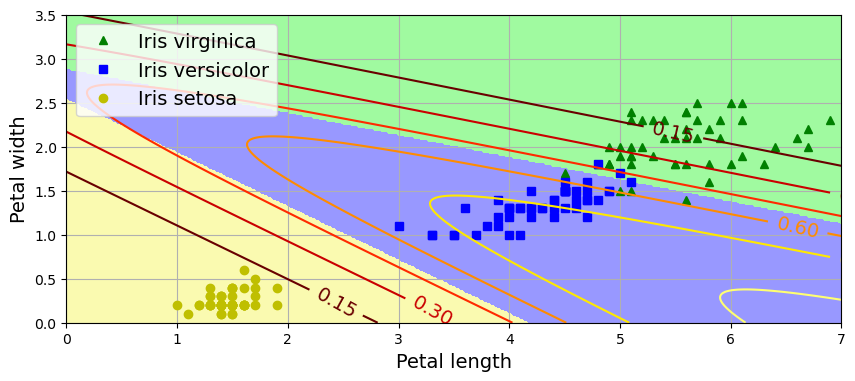

In [ ]:
from matplotlib.colors import ListedColormap

# 붓꽃 데이터셋 산점도
plt.figure(figsize=(10, 4))
plt.plot(X[y == 2, 0], X[y == 2, 1], "g^", label="Iris virginica")
plt.plot(X[y == 1, 0], X[y == 1, 1], "bs", label="Iris versicolor")
plt.plot(X[y == 0, 0], X[y == 0, 1], "yo", label="Iris setosa")

# 배경화면 그리기
custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])

## 배경화면 데이터셋
x0, x1 = np.meshgrid(np.linspace(0, 8, 500).reshape(-1, 1),
                     np.linspace(0, 3.5, 200).reshape(-1, 1))

## 데이터 표준화
X_new = np.c_[x0.ravel(), x1.ravel()]
X_new = (X_new - mean) / std
X_new_with_bias = np.c_[np.ones(len(X_new)), X_new]

## 배경화면 데이터셋에 대한 예측값
logits = X_new_with_bias @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

## 버시컬러 품종일 확률
zz1 = Y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

# 배경화면 색상 지정
plt.contourf(x0, x1, zz, cmap=custom_cmap)
# 등고선 그리기
contour = plt.contour(x0, x1, zz1, cmap="hot")

# 기타
plt.clabel(contour, inline=1)
plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.legend(loc="upper left")
plt.axis([0, 7, 0, 3.5])
plt.grid()
plt.show()

**테스테셋에 대한 모델의 정확도**

In [ ]:
logits = X_test @ Theta
Y_proba = softmax(logits)
y_predict = Y_proba.argmax(axis=1)

accuracy_score = (y_predict == y_test).mean()
accuracy_score

0.9666666666666667

테스트셋에 대한 성능이 검증셋에 대한 성능보다 좋다.
하지만 이는 일반적이지 않다.
이유는 아마도 붓꽃 데이터셋이 꽤 작은 편이라 데이터가 어떻게 섞였는가에 따라 결과가 많이 달라질 수 있다.

**과제**

`random.seed()` 함수의 인자를 42가 아닌 다른 값으로 지정한 다음에 직접 구현한 소프트맥스 회귀 모델을 붓꽃 데이터셋에 적용하여
다른 성능의 모델을 학습시키는지 여부를 확인하라.